<a href="https://colab.research.google.com/github/czengnn/lana-del-rey-lyrics-generator/blob/main/Model_no_linebreak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import HTML, display

def set_css():
    display(HTML('''<style> pre {white-space: pre-wrap;} </style>'''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
import pandas as pd 
import numpy as np 
import re 
import os
import time
import pickle
import matplotlib.pyplot as plt


import tensorflow as tf
import keras 
print(tf.__version__)
print(keras.__version__)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.losses import sparse_categorical_crossentropy

from keras.models import Sequential
from keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed, Bidirectional
from keras.callbacks import ModelCheckpoint
from keras import backend as K

2.4.1
2.4.3


In [3]:
# load songs
songs = pd.read_csv('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/data/lana_lyrics_98.csv')
songs.shape

(98, 2)

In [14]:
# put lyrics into 1 string
text = ''
for song in songs['lyrics']:
    text = text + song.lower()
    
# remove the text with brackets around them, such as [Verse 1]
text = re.sub(r'\[[^][]*\]', '', text)
text = re.sub(r'\(|\)', '', text)

corpus = text.split()
corpus[:50]

['why?',
 '"got',
 'that?"',
 'who,',
 'me?',
 '"louder!"',
 'why?',
 '"got',
 'that?"',
 'feet',
 "don't",
 'fail',
 'me',
 'now',
 'take',
 'me',
 'to',
 'the',
 'finish',
 'line',
 'oh,',
 'my',
 'heart,',
 'it',
 'breaks',
 'every',
 'step',
 'that',
 'i',
 'take',
 'but',
 "i'm",
 'hoping',
 'at',
 'the',
 'gates,',
 "they'll",
 'tell',
 'me',
 'that',
 "you're",
 'mine',
 'walking',
 'through',
 'the',
 'city',
 'streets,',
 'is',
 'it',
 'by']

In [33]:
tokenizer.texts_to_sequences(["i'm", "that"])[0]

[11]

In [15]:
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(corpus)
# with open('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/tokenizer2.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)


# load saved tokenizer
with open('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/tokenizer2.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

total_words = len(tokenizer.word_index) + 1
print(total_words)

2556


In [9]:
seq_length = 50

input_sequences = []
for j in range(len(corpus)-seq_length):
    sequence = corpus[j:j+seq_length]
    token_list = tokenizer.texts_to_sequences([sequence])[0]
    input_sequences.append(token_list)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen = max_sequence_len, padding='pre'))

In [10]:
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
predictors.shape, label.shape

((31786, 49), (31786,))

In [20]:
K.clear_session()

def sparse_cat_loss(y_true,y_pred):
    return sparse_categorical_crossentropy(y_true, y_pred, from_logits=False)

vocab_size = total_words
embed_dim = 50
def create_model(vocab_size, embed_dim):
    model = Sequential()
    model.add(Embedding(vocab_size, embed_dim, input_length=max_sequence_len-1))

    # Add an LSTM Layer
    model.add(Bidirectional(LSTM(150, return_sequences=True)))
    # A dropout layer for regularisation
    model.add(Dropout(0.2))
    # Add another LSTM Layer
    model.add(LSTM(100,return_sequences=False))
    # model.add(Dropout(0.1))
    model.add(Dense(vocab_size/2)) #activation='relu'
    # In the last layer, the shape should be equal to the total number of words present in our corpus
    model.add(Dense(vocab_size, activation='softmax'))
    return model

model = create_model(vocab_size, embed_dim)
model.compile(loss=sparse_cat_loss, optimizer='adam', metrics='accuracy')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 49, 50)            127800    
_________________________________________________________________
bidirectional (Bidirectional (None, 49, 300)           241200    
_________________________________________________________________
dropout (Dropout)            (None, 49, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1278)              129078    
_________________________________________________________________
dense_1 (Dense)              (None, 2556)              3269124   
Total params: 3,927,602
Trainable params: 3,927,602
Non-trainable params: 0
______________________________________________

In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(predictors, label, epochs=30, verbose=1, callbacks=[early_stopping])

# Save the weights
model.save_weights('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/ldr_by_word_seq/ldr_by_word_seq')

Epoch 1/30
994/994 [==============================] - 14s 14ms/step - loss: 5.7989 - accuracy: 0.0586
Epoch 2/30
994/994 [==============================] - 14s 14ms/step - loss: 4.9527 - accuracy: 0.1283
Epoch 3/30
994/994 [==============================] - 14s 14ms/step - loss: 4.1526 - accuracy: 0.2259
Epoch 4/30
994/994 [==============================] - 14s 14ms/step - loss: 3.4390 - accuracy: 0.3203
Epoch 5/30
994/994 [==============================] - 14s 14ms/step - loss: 2.8391 - accuracy: 0.4099
Epoch 6/30
994/994 [==============================] - 14s 14ms/step - loss: 2.3653 - accuracy: 0.4902
Epoch 7/30
994/994 [==============================] - 14s 14ms/step - loss: 1.9704 - accuracy: 0.5615
Epoch 8/30
994/994 [==============================] - 14s 14ms/step - loss: 1.6672 - accuracy: 0.6196
Epoch 9/30
994/994 [==============================] - 14s 14ms/step - loss: 1.4204 - accuracy: 0.6690
Epoch 10/30
994/994 [==============================] - 14s 14ms/step - loss: 1.226

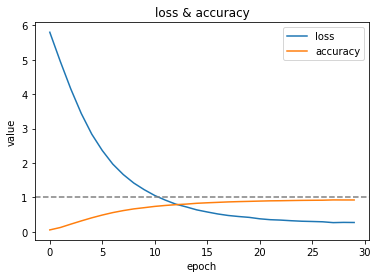

In [23]:
# summarize history for accuracy
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['accuracy'], label='accuracy')
plt.axhline(y=1, color='gray', linestyle='--')
plt.title('loss & accuracy')
plt.ylabel('value')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [24]:
# load saved tokenizer
with open('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/tokenizer2.pkl', 'rb') as f:
    tokenizer_reload = pickle.load(f)

# Create a new model instance
model_loaded = create_model(vocab_size, embed_dim)
model_loaded.load_weights('/content/drive/MyDrive/repos/lana-del-rey-lyrics-generator/models/ldr_by_word_seq/ldr_by_word_seq')
model_loaded.compile(loss=sparse_cat_loss, optimizer='adam', metrics='accuracy')

In [25]:
def make_lyrics(model, seed_text, next_words, tokenizer=tokenizer_reload):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list],
                     maxlen=max_sequence_len-1,padding='pre')
        predicted = np.argmax(model.predict(token_list, verbose=0), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

In [27]:
predicted_lyrics = make_lyrics(model_loaded, 'you\'re so art deco out on the floor shining like gun metal', 100)
print(predicted_lyrics)

you're so art deco out on the floor shining like gun metal you're a anthem and a show i'm a da a whore can even kind look at night when you the refuse see out that time the other woman never was no fear you're tired of an early you were doing the hold and all i leave if you wanna stay yeah fuck i love you never moved to leave if you wanna come yeah all the blues said don't you take you to wanna but we won't think about last the way you've got the two the blues left the vines don't even want we won't think we won't grow


In [28]:
predicted_lyrics = make_lyrics(model_loaded, 'I can see my sweet boy swinging', 100)
print(predicted_lyrics)

I can see my sweet boy swinging my blue only babe and what can i life is but you don't wanna break but you don't wanna say you like to heart you don't wanna break your love everything you hold me or bad honey most of them to my baby that's what you not a would say to me but you are been who you wanna break you don't give me out of that through revenge day and you stevie is sweet or follow you could anyone get i'm not a powerful people are powerful beings tryin' to find the power in me to be faithful change
